In [71]:
import numpy as np
import pandas as pd
#import healpy as hp
#import GCRCatalogs
import os, sys
#from GCR import GCRQuery
#from sqlalchemy import create_engine
import mog_utils
import units
import matplotlib.pyplot as plt
import matplotlib as mpl
#from lsst.sims.utils import angularSeparation

%matplotlib inline
%load_ext autoreload
%autoreload 2
pd.options.display.max_columns = None

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## SN sampler from Gaussian mixture PDF 

Author: Ji Won Park (@jiwoncpark) via discussions with Rahul Biswas (@rbiswas4)

Last Run: 4/30/2019

- __Objective__: Given host galaxy properties, sample the location of SN.
- __Motivation__: We can obtain a Gaussian mixture approximation to the Sersic bulge+disk profile of the host galaxy. (See notebook `host_surface_brightness.ipynb`.) Since the number of stars at a location is ~proportional to the brightness there, we can sample a star from the host galaxy by sampling from a Gaussian mixture PDF proportional to its surface brightness. If we further assume that each star has the same fixed probability of becoming a supernova, this is like sampling the location of SN within the host.
- __Assumptions__: 
    - The host galaxies in the SN DB follow the natural distribution. 
    - Number of stars at an (ra, dec) position is proportional to the surface brightness evaluated at that point.
    - All stars have the same fixed probability of becoming SNs.

### 1. Get GMM parameters from Sersic host galaxy

In [4]:
# Function version of the host_surface_brightness.ipynb notebook
def get_gmm_params(hostgal, psf_fwhm=0.7):
    """Approximates an elliptical Sersic profile as a mixture of 18 elliptical Gaussians
    
    Parameters
    ----------
    hostgal : Pandas DataFrame (or dictionary) containing columns (keys) noted below.
    psf_fwhm : FWHM of a circular Gaussian PSF
    
    Note
    ----
    The input hostgal must contain all the columns (keys) in the following list `quantities_needed`:
    >>> quantities_needed = ['galaxy_id', 'ra_true', 'dec_true', 'bulge_to_total_ratio_i',]
    >>> quantities_needed += ['mag_true_%s_lsst' %bp for bp in 'ugrizY']
    >>> quantities_needed += ['size_true', 'ellipticity_true', 'position_angle_true',]
    >>> morph_cols = ['size_%s_true', 'size_minor_%s_true', 'ellipticity_1_%s_true', 'ellipticity_2_%s_true']
    >>> for component in ['bulge', 'disk']:
    >>>     quantities_needed += [morph %component for morph in morph_cols]
    
    Returns
    -------
    A Pandas DataFrame containing parameters of the 18 elliptical Gaussians
    """
    
    # Format catalog with unit conversions and column renaming
    hostgal_formatted = mog_utils._format_extragal_catalog(hostgal)
    # Separate galaxy catalog into bulge and disk --> params of 2 Sersics
    bulge, disk, _ = mog_utils.separate_bulge_disk(hostgal_formatted)
    # Deconstruct bulge/disk into MoG --> Params of 18 Gaussians
    bulge_mog = mog_utils.sersic_to_mog(sersic_df=bulge, bulge_or_disk='bulge')
    disk_mog = mog_utils.sersic_to_mog(sersic_df=disk, bulge_or_disk='disk')
    # Concat bulge and disk MoGs
    full_mog = pd.concat([bulge_mog, disk_mog], axis=0)
    return full_mog

In [31]:
# Read in a single host galaxy
hostgal = pd.read_csv('hostgal_small.csv', index_col=False, nrows=1)
# Return GMM params
gmm_params = get_gmm_params(hostgal, psf_fwhm=0.7)

In [32]:
gmm_params.shape, gmm_params.columns.values

((18, 12),
 array(['galaxy_id', 'ra', 'dec', 'e', 'phi', 'gauss_sigma', 'flux_u',
        'flux_g', 'flux_r', 'flux_i', 'flux_z', 'flux_Y'], dtype=object))

### 2. Normalize GMM surface brightness into PDF

In [42]:
def normalize_gmm(gmm_params):
    """Normalizes the per-band fluxes of the 18 Gaussian components
    so that they add to 1
    """
    # Weights are same across bands, since bulge-to-disk ratio is same
    flux_in_r = gmm_params['flux_r'].values
    total_flux_in_r = np.sum(flux_in_r)
    weight = flux_in_r/total_flux_in_r
    assert np.isclose([np.sum(weight)], [1.0])
    return weight

In [43]:
weight = normalize_gmm(gmm_params)

### 3. Sample from GMM PDF

In [80]:
def sample_radec_from_gmm(gmm_params, num_samples=1):
    """ Samples ra, dec from given GMM PDF
    """
    num_gaussians, _ = gmm_params.shape
    probs = normalize_gmm(gmm_params)
    
    # Initialize sample array
    samples = np.empty([num_samples, 2])
    for sample_idx in range(num_samples):
        # Categorical pick of Gaussian component among num_components
        which_gaussian_idx = np.random.choice(num_gaussians, size=None, p=probs)
        which_gaussian = gmm_params.iloc[which_gaussian_idx]
        # Sample from picked Gaussian
        samples[sample_idx, :] = mog_utils.sample_from_chosen_gaussian(which_gaussian)
    # Add central ra, dec
    zeropoint_ra = gmm_params.iloc[0]['ra']
    zeropoint_dec = gmm_params.iloc[0]['dec']
    samples[:, 0] += zeropoint_ra
    samples[:, 1] += zeropoint_dec
    return samples, zeropoint_ra, zeropoint_dec

In [97]:
# Takes ~10s per galaxy
test_num_samples = 10000
samples, ra_0, dec_0 = sample_radec_from_gmm(gmm_params, num_samples=test_num_samples)

### 4. Visualize
Sersic has a very cuspy center so we'll need many samples to recover the original profile. For visualization, log scale is best.

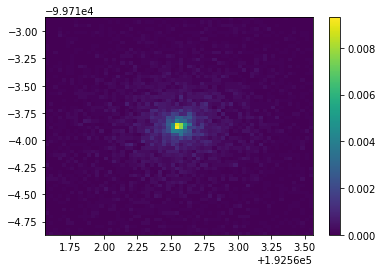

In [101]:
sampled_ra = samples[:, 0]
sampled_dec = samples[:, 1]
num_bins = 64
radius = 1.0 # arcsec
around_center = [[ra_0 - radius, ra_0 + radius], [dec_0 - radius, dec_0 + radius]]
_ = plt.hist2d(sampled_ra, sampled_dec, bins=(num_bins, num_bins), range=around_center,
               weights=np.ones(test_num_samples)/test_num_samples)
               #norm=mpl.colors.LogNorm(),)#, cmap=mpl.cm.gray)
plt.colorbar()

Compare with input Gaussian mixture PDF

In [ ]:
# TODO
# Make GMM in astropy
# Render PDF as image